## Predicting House Prices using Random Forest
This project is a showcase on how to use scikit-learn's Random Forest Regressor to predict house prices based on given features. Dataset is provided by [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
### Preparing the Data
First thing first, we import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None


We were given 2 datasets in this project, 1 to train the model and the other to score our model against other people's model. The given data need to be loaded as a pandas dataframe for exploration.

In [2]:
df1=pd.read_csv('train.csv')
df2=pd.read_csv('test.csv')

Dropping the 'Id' column because it's irrelevant in training our model but we need to save the 'Id' column of the test dataset for scoring purposes later.

In [3]:
testid=df2['Id']

df1.drop('Id', axis=1, inplace=True)
df2.drop('Id', axis=1, inplace=True)

On the documentation accompanying the dataset, it was said that there are some outliers. We use a scatter plot to visualizes those outliers.

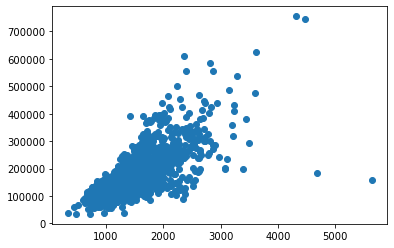

In [4]:
plt.scatter(df1.GrLivArea, df1.SalePrice)
plt.show()

We can see that there are some outliers in the data. We will drop all data where 'GrLivArea' is over 4000

In [5]:
df1 = df1.drop(df1[df1['GrLivArea']>4000].index)

### Feature Engineering
We want to make sure that our dataset is ready for model training. We need to manipulate the features so it is machine readable. First of all we need to concatenate our train and test dataset and do the necessary manipulations simultaneously on both dataset. We save the number of rows of the first dataset so we can split them again later.

In [6]:
X=pd.concat((df1, df2))

n=df1.shape[0]

X.drop('SalePrice', axis=1, inplace=True)
y=df1['SalePrice']

To search for missing values, we define a simple function.

In [7]:
def missing(col):
    return col.isna().sum().sort_values(ascending=False)

We need to split our numerical and categorical features because different method will be used to impute missing values. But there are some numerical columns which are actually categorical so we want to change the datatype on those columns.

In [8]:
X['YrSold']=X['YrSold'].astype(str)
X['MoSold']=X['MoSold'].astype(str)
X['GarageYrBlt']=X['GarageYrBlt'].astype(str)
num=X.select_dtypes('number')
cat=X.select_dtypes('object')

We use our function we have defined earlier to look for missing values in numerical columns

In [9]:
missing(num)

LotFrontage      486
MasVnrArea        23
BsmtFullBath       2
BsmtHalfBath       2
BsmtFinSF1         1
TotalBsmtSF        1
BsmtUnfSF          1
GarageArea         1
GarageCars         1
BsmtFinSF2         1
1stFlrSF           0
YearRemodAdd       0
LowQualFinSF       0
YearBuilt          0
OverallCond        0
OverallQual        0
LotArea            0
2ndFlrSF           0
MiscVal            0
GrLivArea          0
PoolArea           0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
MSSubClass         0
dtype: int64

For columns related to basement or mason veneer, the missing values probably just mean that the houses don't have basement or mason veneer to begin with, so we can simply impute the missing values with 0.

In [10]:
missing_num=['MasVnrArea', 'BsmtHalfBath', 'BsmtFullBath','GarageArea',
             'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF',
             'GarageCars']
num[missing_num]=num[missing_num].fillna(0)

For 'LotFrontage' we will use k-nearest-neighbour imputer

In [11]:
from sklearn.impute import KNNImputer

knnimp=KNNImputer()
num=pd.DataFrame(knnimp.fit_transform(num), columns=num.columns)

Next, we want to see missing values on the categorical columns

In [12]:
missing(cat)

PoolQC           2907
MiscFeature      2810
Alley            2717
Fence            2345
FireplaceQu      1420
GarageCond        159
GarageQual        159
GarageFinish      159
GarageType        157
BsmtCond           82
BsmtExposure       82
BsmtQual           81
BsmtFinType2       80
BsmtFinType1       79
MasVnrType         24
MSZoning            4
Functional          2
Utilities           2
Electrical          1
Exterior1st         1
KitchenQual         1
Exterior2nd         1
SaleType            1
LandSlope           0
Condition1          0
Neighborhood        0
LandContour         0
LotConfig           0
BldgType            0
LotShape            0
YrSold              0
Street              0
Condition2          0
RoofMatl            0
HouseStyle          0
RoofStyle           0
CentralAir          0
MoSold              0
ExterQual           0
ExterCond           0
Foundation          0
PavedDrive          0
GarageYrBlt         0
Heating             0
HeatingQC           0
SaleCondit

Most of the missing values on the categorical columns are just house features that may or may not be present on every house. We will assume that the houses with missing values don't have those features. We impute the missing values with 'None'

In [13]:
cat=cat.fillna('None')

Let's check for missing values after imputing.

In [14]:
missing(num)

MiscVal          0
GrLivArea        0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       0
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
BsmtFullBath     0
PoolArea         0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
MSSubClass       0
dtype: int64

In [15]:
missing(cat)

SaleCondition    0
BldgType         0
Foundation       0
ExterCond        0
ExterQual        0
MasVnrType       0
Exterior2nd      0
Exterior1st      0
RoofMatl         0
RoofStyle        0
HouseStyle       0
Condition2       0
SaleType         0
Condition1       0
Neighborhood     0
LandSlope        0
LotConfig        0
Utilities        0
LandContour      0
LotShape         0
Alley            0
Street           0
BsmtQual         0
BsmtCond         0
BsmtExposure     0
BsmtFinType1     0
YrSold           0
MoSold           0
MiscFeature      0
Fence            0
PoolQC           0
PavedDrive       0
GarageCond       0
GarageQual       0
GarageFinish     0
GarageYrBlt      0
GarageType       0
FireplaceQu      0
Functional       0
KitchenQual      0
Electrical       0
CentralAir       0
HeatingQC        0
Heating          0
BsmtFinType2     0
MSZoning         0
dtype: int64

Looks like we're good to go. The next step is to use LabelEncoder to change the categorical values to machine-readable format.

In [16]:
from sklearn.preprocessing import LabelEncoder

for col in cat.columns:
    le=LabelEncoder()
    le.fit(list(cat[col].values))
    cat[col]=le.transform(list(cat[col].values))

### Preparing the Data for Model Training
After we finished doing some feature engineering, we concatenate the numerical and categorical column to prepare our data for model training.

In [17]:
num.reset_index(drop=True, inplace=True)
cat.reset_index(drop=True, inplace=True)

whole=pd.concat([cat, num], axis=1)
whole=pd.get_dummies(whole)

First step in machine learning is to define our train and test set, we use sklearn's train_test_split to split our train data (from 0-th row to n-th row). We also import and instantiate RandomForestRegressor as our estimator.

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(whole[:n], y, test_size=0.1)

from sklearn.ensemble import RandomForestRegressor

rf=RandomForestRegressor()

### Hyperparameter Tuning
We use the sklearn's RandomizedSearchCV to find the best hyperparameters for our model.

In [19]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,
                               n_iter = 100, cv = 3, random_state=42,
                               n_jobs = -1)

The best hyperparameters for our model according to RandomizedSearchCV are:

In [20]:
rf_random.fit(X_train, y_train)
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 70,
 'bootstrap': False}

### Predicting the SalePrice
We use the best estimator, which is RandomForestRegressor with best parameters and fit it to our training set.

In [21]:
model=rf_random.best_estimator_
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, max_depth=70, max_features='sqrt',
                      min_samples_split=5, n_estimators=1600)

We then predict the SalePrice using our trained model on the test set (n-th row to last row)

In [22]:
y_pred=model.predict(whole[n:])

The prediction must be submitted using the requested format by Kaggle which is a csv file containing 'Id' and 'SalePrice'

In [23]:
submission=pd.DataFrame({
                        'Id' : testid,
                        'SalePrice': y_pred })

submission.to_csv('submission.csv', index=False)

Submitting the file to Kaggle yields a Root Mean Squared Logarithmic Error of 0.14721